# Monolithic Recurrent Neural Network

Vectorized 2-layer fully-connected recurrent neural network with cross-entropy loss. Includes support for:

- Minibatching
- Optional gradient checking
- L2 Regularization
- Logging so you can see what the scores, probabilities, gradients, etc. are after every minibatch

This is a shallow network with hard-coded sigmoid units. Additionally this architecture assumes each sequence is the same length!

In [1]:
from collections import namedtuple

State = namedtuple('State', ['loss', 'dWhh', 'dbhh', 'dWxh', 'dbxh', 'dWs', 'dbs'])
Snapshot = namedtuple('State', ['xs', 'ys', 'Whh', 'bhh', 'Wxh', 'bxh', 'Ws', 'bs', 'dWhh', 'dbhh', 'dWxh', 'dbxh', 'dWs', 'dbs', 'dhiddens', 'dhiddens_local', 'dhiddens_downstream', 'scores', 'loss'])

In [118]:
from nn.shallow.helper import sigmoid, sigmoid_grad
from softmax import softmax_vectorized

class RecurrentNeuralNetwork:
    """Initialize model parameters
    
    Additionally calculate batch index so we can use minibatches with each training iteration
    
    If you want to inspect the scores after each training example, the pass inspect. If you do
    this then you better set a batch_size to 1. Otherwise you'll only ever get the scores of
    the last training example in the minibatch
    
    """
    def __init__(self, X, ys_train, H, C,
                 Whh=None, bhh=None, Wxh=None, bxh=None, Ws=None, bs=None,
                 rollout=None, learning_rate=0.001, regularizer=1.,
                gradient_checking=False, inspect=False):
        """Initializes recurrent neural network classifier
        
        Parameters
        ----------
        X : N x M 2d array containing all elements in the sequence
        ys_train : length M list of labels
        H : size of hidden layer
        C : number of target classes
        Whh : H x H 2d matrix mapping previous hidden layer to new hidden layer
        bhh : H x 1 array of bias terms applied after Whh multiplication
        Wxh : H x N 2d matrix mapping input at time t to hidden size
        bxh : H x 1 array of bias terms applied after Wxh multiplication
        Ws : C x H matrix of softmax weights
        bs : C x 1 array of softmax biases
        rollout : the number of tokens to train the rnn on in one go
        learning_rate : learning rate constant
        regularizer : regularization constant
        gradient_checking : boolean whether to perform gradient checking during training
        inspect : boolean whether to log all data after every learning session from a training example
        
        """
        (self.N, self.M) = X.shape
        self.H = H
        
        self.X_train, self.ys_train = X, ys_train
        
        # Hidden and input weights
        self.Whh = np.random.randn(H, H) if not type(Whh) == np.ndarray else Whh
        self.bhh = np.random.randn(H, 1) if not type(bhh) == np.ndarray else bhh
        self.Wxh = np.random.randn(H, self.N) if not type(Wxh) == np.ndarray else Wxh
        self.bxh = np.random.randn(H, 1) if not type(bxh) == np.ndarray else bxh
        
        # Softmax weights
        self.Ws = np.random.randn(C, H) if not type(Ws) == np.ndarray else Ws
        self.bs = np.random.randn(C, 1) if not type(bs) == np.ndarray else bs
        
        self.rollout = self.M if not rollout else rollout
        self.learning_rate = learning_rate
        self.regularizer = regularizer
        
        self.gradient_checking = gradient_checking
        self.inspect = inspect
        
        self.train_index = 0
        
    def predict(self, X):
        """Return the probability of x belonging to either class"""
        
        # Create artificial labels just to make forward_backward_prop() happy
        N, T = X.shape
        ys = np.ones(T, dtype=np.int)
        
        scores = self.forward_backward_prop(X, ys, rollout=T, predict=True)
        proper_scores = np.hstack([score for t, score in sorted(scores.items())])
        
        return proper_scores, proper_scores.argmax(axis=0)
        
    def forward_backward_prop(self, X=None, ys=None, rollout=None, train_index=None, Whh=None, bhh=None, Wxh=None, bxh=None, Ws=None, bs=None, predict=False):
        """Perform forward and backward prop over a single training example
        
        Returns loss and gradients
        
        """
        # Hidden and input weights
        Whh = self.Whh if not type(Whh) == np.ndarray else Whh
        bhh = self.bhh if not type(bhh) == np.ndarray else bhh
        Wxh = self.Wxh if not type(Wxh) == np.ndarray else Wxh
        bxh = self.bxh if not type(bxh) == np.ndarray else bxh
        
        # Softmax weights
        Ws = self.Ws if not type(Ws) == np.ndarray else Ws
        bs = self.bs if not type(bs) == np.ndarray else bs
        
        # rollout and train_index will be set to T and 0 respectively if we are predicting
        rollout = self.rollout if not rollout else rollout
        train_index = self.train_index if not train_index else train_index
        
        # Passed in X to predict?
        X = self.X_train[:, train_index:train_index+rollout] if not type(X) == np.ndarray else X
        ys = self.ys_train[train_index:train_index+rollout] if not type(ys) == np.ndarray else ys
        
        # Append column of zeros to align X and Y with natural time
        N, T = X.shape
        X, ys = np.hstack([np.zeros((N, 1)), X]), np.hstack([np.zeros(1, dtype=np.int), ys])
        
        # Forward pass!
        dWhh, dbhh = np.zeros_like(Whh), np.zeros_like(bhh)
        dWxh, dbxh = np.zeros_like(Wxh), np.zeros_like(bxh)
        dWs, dbs = np.zeros_like(Ws), np.zeros_like(bs)
        
        loss = 0.
        hiddens, dhiddens = {t:np.ones((self.H, 1)) for t in range(rollout+1)}, {t:np.zeros((self.H, 1)) for t in range(rollout+1)}
        dhiddens_downstream, dhiddens_local = {t:np.zeros((self.H, 1)) for t in range(rollout+1)}, {t:np.zeros((self.H, 1)) for t in range(rollout+1)}
        scores, probs = {t:None for t in range(1, rollout+1)}, {t:None for t in range(1, rollout+1)}
        for t in range(1, T+1):
            # Previous hidden layer and input at time t
            Z = (Whh @ hiddens[t-1] + bhh) + (Wxh @ X[:,[t]] + bxh)
            hiddens[t] = sigmoid(Z)
            
            # Softmax
            scores[t] = Ws @ hiddens[t] + bs
            probs[t] = softmax_vectorized(scores[t])
            y_hat = probs[t][ys[t]]

            # Loss
            loss += -np.log(y_hat).sum()

        # Add regularization
        loss += self.regularizer * 0.5*(np.sum(Whh**2) + np.sum(bhh**2) +
                                        np.sum(Wxh**2) + np.sum(bxh**2) +
                                        np.sum(Ws**2) + np.sum(bs**2))
        if predict:
            return scores
        
        # Backpropagate!
        backwards = list(reversed(range(T+1)))
        for t in backwards[:-1]:
            # Scores
            dscores = probs[t]
            dscores[ys[t], 0] -= 1

            # Softmax weights
            dbs += dscores
            dWs += dscores @ hiddens[t].T

            # Karpathy optimization
            dhiddens_local[t] = Ws.T @ dscores
            dhiddens[t] = dhiddens_local[t] + dhiddens_downstream[t]
            
            dZ = sigmoid_grad(hiddens[t]) * dhiddens[t]

            # Input and hidden weights
            dbxh += dZ
            dWxh += dZ @ X[:,[t]].T
            dbhh += dZ
            dWhh += dZ @ hiddens[t-1].T
            
            # Set up incoming hidden weight gradient for previous time step
            dhiddens_downstream[t-1] = Whh.T @ dZ
        
        # Regularization
        #
        # Hidden and input weights
        dWhh += (self.regularizer*Whh)
        dbhh += (self.regularizer*bhh)
        dWxh += (self.regularizer*Wxh)
        dbxh += (self.regularizer*bxh)
        
        # Softmax weights
        dWs += (self.regularizer*Ws)
        dbs += (self.regularizer*bs)
        
        # Log additional info?
        if self.inspect:
            self.xs, self.ys = str(X[:, 1:]), str(ys[1:])
            self.scores, self.probs = scores, probs
            self.loss = loss
            self.dWhh, self.dbhh, self.dWxh, self.dbxh = dWhh, dbhh, dWxh, dbxh
            self.dWs, self.dbs = dWs, dbs
            self.dhiddens = dhiddens
            self.dhiddens_local, self.dhiddens_downstream = dhiddens_local, dhiddens_downstream
        
        return State(loss, dWhh, dbhh, dWxh, dbxh, dWs, dbs)
    
    def learn(self):
        """Learn from a minibatch of training examples
        
        Run gradient descent on these examples
        
        """
        loss, dWhh, dbhh, dWxh, dbxh, dWs, dbs = self.forward_backward_prop()

        self.gradient_check(dWhh, dbhh, dWxh, dbxh, dWs, dbs)
        
        # Hidden and input weights
        self.Whh = self.Whh - self.learning_rate*dWhh
        self.bhh = self.bhh - self.learning_rate*dbhh
        self.Wxh = self.Wxh - self.learning_rate*dWxh
        self.bxh = self.bxh - self.learning_rate*dbxh
        
        # Softmax weights
        self.Ws = self.Ws - self.learning_rate*dWs
        self.bs = self.bs - self.learning_rate*dbs
        
        # Update batch index so the next time the next batch in line is used
        self.train_index = (self.train_index+self.rollout) % self.M
        
        # Log additional info?
        if self.inspect:
            pass
    
    def gradient_check(self, analytic_dWhh, analytic_dbhh, analytic_dWxh, analytic_dbxh, analytic_dWs, analytic_dbs):
        """Verify gradient correctness
        
        The analytic dWhh, dbhh, dWxh, dbxh, dWs, and dbs come from doing forward-backward
        prop just a second ago. We numerically estimate these gradients on
        the *same* minibatch the analytic gradients were computed from and
        compare them to see if they are close.
        
        Note the same rollout is being used because this function gets
        called *before* the update to batch_index
        
        """
        if not self.gradient_checking:
            return
        
        num_dWhh, num_dbhh, num_dWxh, num_dbxh, num_dWs, num_dbs = self.numerical_gradients()

        # Compute relative error
        #
        # Hidden and input differences
        dWhh_error = abs(num_dWhh- analytic_dWhh) / (abs(num_dWhh) + abs(analytic_dWhh))
        dbhh_error = abs(num_dbhh - analytic_dbhh) / (abs(num_dbhh) + abs(analytic_dbhh))
        dWxh_error = abs(num_dWxh- analytic_dWxh) / (abs(num_dWxh) + abs(analytic_dWxh))
        dbxh_error = abs(num_dbxh - analytic_dbxh) / (abs(num_dbxh) + abs(analytic_dbxh))
        
        # Softmax differences
        dWs_error = abs(num_dWs - analytic_dWs) / (abs(num_dWs) + abs(analytic_dWs))
        dbs_error = abs(num_dbs - analytic_dbs) / (abs(num_dbs) + abs(analytic_dbs))

        try:
            assert(np.linalg.norm(dWhh_error) < 1e-6 and np.linalg.norm(dbhh_error) < 1e-6 and
                   np.linalg.norm(dWxh_error) < 1e-6 and np.linalg.norm(dbxh_error) < 1e-6 and
                   np.linalg.norm(dWs_error) < 1e-6 and np.linalg.norm(dbs_error) < 1e-6)
        except AssertionError:
            warn('Gradient check failed!')
            
            # Hidden and input differences
            warn('dWhh relative error: {}'.format(dWhh_error))
            warn('dbhh relative error: {}'.format(dbhh_error))
            warn('dWxh relative error: {}'.format(dWxh_error))
            warn('dbxh relative error: {}'.format(dbxh_error))
            
            # Softmax differences
            warn('dWs relative error: {}'.format(dWs_error))
            warn('dbs relative error: {}'.format(dbs_error))
            
    def numerical_gradients(self):
        """Compute numerical gradients of f with respect to self.Whh, self.bhh, self.Wxh, self.bxh, self.Ws, and self.bs

        Returns approximation for df/dWhh, df/dbhh, df/dWhh, df/dbhh, df/dWs, df/dbs

        """
        dWhh, dbhh = np.zeros_like(self.Whh), np.zeros_like(self.bhh)
        dWxh, dbxh = np.zeros_like(self.Wxh), np.zeros_like(self.bxh)
        dWs, dbs = np.zeros_like(self.Ws), np.zeros_like(self.bs)
        
        Whh, bhh, Wxh, bxh, Ws, bs = self.Whh, self.bhh, self.Wxh, self.bxh, self.Ws, self.bs
        
        step = 1e-5
    
        # df/dWhh
        h = np.zeros_like(self.Whh)
        it = np.nditer(Whh, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dWhh[ix] = (self.forward_backward_prop(Whh=Whh+h).loss - self.forward_backward_prop(Whh=Whh-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dbhh
        h = np.zeros_like(self.bhh)
        it = np.nditer(bhh, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dbhh[ix] = (self.forward_backward_prop(bhh=bhh+h).loss - self.forward_backward_prop(bhh=bhh-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dWxh
        h = np.zeros_like(self.Wxh)
        it = np.nditer(Wxh, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dWxh[ix] = (self.forward_backward_prop(Wxh=Wxh+h).loss - self.forward_backward_prop(Wxh=Wxh-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dbhh
        h = np.zeros_like(self.bxh)
        it = np.nditer(bxh, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dbxh[ix] = (self.forward_backward_prop(bxh=bxh+h).loss - self.forward_backward_prop(bxh=bxh-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dWs
        h = np.zeros_like(self.Ws)
        it = np.nditer(Ws, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dWs[ix] = (self.forward_backward_prop(Ws=Ws+h).loss - self.forward_backward_prop(Ws=Ws-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()
            
        # df/dbs
        h = np.zeros_like(self.bs)
        it = np.nditer(bs, flags=['multi_index'])
        while not it.finished:
            ix = it.multi_index
            h[ix] = step
            
            dbs[ix] = (self.forward_backward_prop(bs=bs+h).loss - self.forward_backward_prop(bs=bs-h).loss) / (2*step)

            h[ix] = 0
            it.iternext()

        return dWhh, dbhh, dWxh, dbxh, dWs, dbs

    @property
    def info(self):
        """Get a snapshot of the model's most recent activity"""
        
        return Snapshot(self.xs, self.ys,
                        self.Whh, self.bhh, self.Wxh, self.bxh, self.Ws, self.bs,
                        self.dWhh, self.dbhh, self.dWxh, self.dbxh, self.dWs, self.dbs,
                        self.dhiddens, self.dhiddens_local, self.dhiddens_downstream,
                        self.scores, self.loss)

### Learn it!

In [128]:
from data.rnn import X_train, Y_train

rnn = RecurrentNeuralNetwork(X_train, Y_train, H=3, C=3, learning_rate=.1, regularizer=0, gradient_checking=False, inspect=True)

def states(iters):
    for _ in range(iters):
        rnn.learn()
        yield rnn.info
        
states = list(states(5000))

df = pd.DataFrame(states, columns=Snapshot._fields)

### Loss

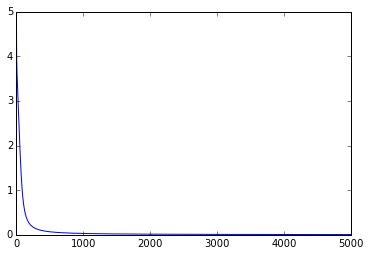

In [129]:
df.loss.plot()

### Plot Scores as RNN Trains Over Time

[[ 1  1 -1  1]]
[0 0 2 1]


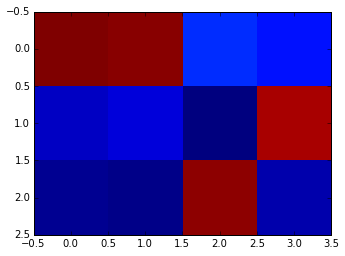

In [130]:
from ipywidgets import interact, fixed

N, T = X_train.shape

@interact(X_train=fixed(X_train), Y_train=fixed(Y_train), iter_index=(0, len(states)-1))
def plot(X_train, Y_train, iter_index):
    s = states[iter_index]
    
    rnn = RecurrentNeuralNetwork(X=X_train, ys_train=Y_train, H=3, C=3,
                                 Whh=s.Whh, bhh=s.bhh, Wxh=s.Wxh, bxh=s.bxh, Ws=s.Ws, bs=s.bs)
    
    scores, predictions = rnn.predict(X_train)
    
    print(X_train)
    print(Y_train)
    
    plt.imshow(scores, interpolation='nearest')